In [25]:
from typing import Tuple, Union, List
import random
import math

class Value:
    def __init__(self, data: float, _children : Tuple['Value', ...] = (), op : str = ''):
        self.data = data
        self.grad = 0
        
        self._op = op
        self._prev = set(_children)
        self._backward = lambda: None

    def __add__(self, rhs: Union[float, 'Value']) -> 'Value':
        rhs = rhs if isinstance(rhs, Value) else Value(data=rhs)
        out = Value(data=self.data + rhs.data, _children=(self, rhs), op = '+')
        
        def _backward():
            self.grad += out.grad
            rhs.grad += out.grad

        out._backward = _backward        
        return out

    def __mul__(self, rhs: Union[float, 'Value']) -> 'Value':
        rhs = rhs if isinstance(rhs, Value) else Value(data=rhs)
        out = Value(data=self.data * rhs.data, _children=(self, rhs), op = '*')
        
        def _backward():
            self.grad += rhs.data * out.grad
            rhs.grad += self.data * out.grad

        out._backward = _backward        
        return out

    def __pow__(self, rhs: Union[float, int]) -> 'Value':
        assert isinstance(rhs, (int, float)), 'only support pow for int & float'        

        # pay attention to the comma after self. Without it, (self) shall "decay" to self, whose type would be Value instead of Tuple
        out = Value(data=self.data ** rhs, _children=(self,), op = f'**{rhs}')
        
        def _backward():
            self.grad += rhs * (self.data ** (rhs - 1)) * out.grad

        out._backward = _backward        
        return out

    def log(self) -> 'Value':
        assert self.data >= 0, 'log can be applied to positive number only'
        out = Value(math.log(max(self.data, 1e-15)), (self,), 'log')

        def _backward():
            self.grad += 1.0 / max(self.data, 1e-15) * out.grad

        out._backward = _backward
        return out
    

    def relu(self) -> 'Value':
        out = Value(0 if self.data < 0 else self.data, (self,), 'relu')

        def _backward():
            self.grad += (0 if self.data < 0 else 1) * out.grad

        out._backward = _backward
        return out

    def tanh(self) -> 'Value':
        # TODO: overflow when self.data is large, need clip

        t = (math.exp(2*self.data)-1) / (math.exp(2*self.data)+1)
        out = Value(t, _children = (self,), op = 'tanh')

        def _backward():
            self.grad += (1 - t*t) * out.grad

        out._backward = _backward
        return out

    def sigmoid(self) -> 'Value':
        if self.data > 15:
            t = 1
        elif self.data < -15:
            t = 0
        else:
            t = 1 / (1 + math.exp(-self.data)) 
        out = Value(t, _children = (self,), op = 'sigmoid')

        def _backward():
            self.grad += t * (1 - t) * out.grad
        out._backward = _backward
        
        return out
        
    def _build_topo(self) -> List['Value']:
        visited = set()
        topo = []
        def _build_topo_inner(v: Value):
            if not v in visited:
                visited.add(v)
                for child in v._prev:
                    _build_topo_inner(child)
                topo.append(v)
        _build_topo_inner(self)
        return topo

    def backward(self):
        topo = self._build_topo()        
        self.grad = 1
        for v in reversed(topo):
            v._backward()
        
    def __neg__(self) -> 'Value':
        return self * -1
    
    def __radd__(self, lhs: float) -> 'Value':
        return self + lhs

    def __rmul__(self, lhs: float) -> 'Value':
        return self * lhs

    def __sub__(self, rhs: Union[float, 'Value']) -> 'Value':
        return self + (-rhs)

    def __rsub__(self, lhs: float) -> 'Value':
        return -self + lhs

    def __truediv__(self, rhs: Union[float, 'Value']) -> 'Value':
        return self * rhs**-1

    def __rtruediv__(self, lhs: float) -> 'Value':
        return lhs * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"




In [26]:
from abc import ABC, abstractmethod
class Module(ABC):
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
    
    @abstractmethod
    def parameters(self) -> List[Value]:
        pass
    
class Neuron(Module):
    def __init__(self, nin: int, non_linear: bool = True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.non_linear = non_linear

    def __call__(self, x: List[Value]) -> Value:
        assert len(x) == len(self.w), f"dimension mismatch: len(w) = {len(self.w)}, len(x) = {len(x)}"
        act = sum(wi*xi for xi, wi in zip(x, self.w)) + self.b
        return act.relu() if self.non_linear else act

    def parameters(self) -> List[Value]:
        return self.w + [self.b]

    def __repr__(self):
        return f"{'Relu' if self.non_linear else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):
    def __init__(self, nin: int, nout: int, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)] 

    def __call__(self, x: List[Value]) -> Union[Value, List[Value]]:
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self) -> List[Value]:
        return [p for n in self.neurons for p in n.parameters() ]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):
    def __init__(self, nin: int, nouts: List[int]):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], non_linear=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x: List[Value]) -> List[Value]:
        out = x
        for l in self.layers:
            out = l(out)
        return out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

[[ 1.12211461  0.08147717]
 [-0.81882941  0.05879006]
 [ 1.61370966 -0.1246459 ]] [0 0 1] (100, 2) (100,)


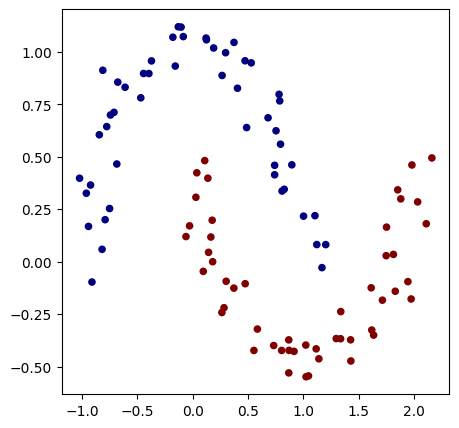

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1337)
random.seed(1337)

# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)
print(X[:3], y[:3], X.shape, y.shape)

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [28]:
model = MLP(2, [16,16,1]) # 2 layer NN
print(model)
print(len(model.parameters())) # (2+1) * 16 + (16+1) * 16 + (16+1) * 1

MLP of [Layer of [ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2), ReluNeuron(2)], Layer of [ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16), ReluNeuron(16)], Layer of [LinearNeuron(16)]]
337


In [29]:
def cross_entropy_loss(gt: float, pred: Value):
    return -(gt * pred.log() + (1-gt)*(1-pred).log())
    
def loss(batch_size = None):
    ypred = [model(x).sigmoid() for x in X]
    data_loss = sum(cross_entropy_loss(yi_gt, yi_pred) for yi_pred, yi_gt in zip(ypred, y)) / len(y)
    reg_loss = 1e-4 * sum(p*p for p in model.parameters())
    total_loss = data_loss + reg_loss
    correct = [1 if (yi_pred.data-0.5)*(yi_gt - 0.5) > 0 else 0 for yi_pred, yi_gt in zip(ypred, y)]
    return total_loss, sum(correct) / len(correct)

def train(nsteps: int):
    for k in range(nsteps):
        total_loss, accuracy = loss()

        model.zero_grad()
        total_loss.backward()

        learning_rate = 1 - 0.9 * (k / nsteps)
        for p in model.parameters():
            p.data -= p.grad * learning_rate

        print(f"step {k} loss {total_loss.data}, accuracy {accuracy*100}%")

train(100)

step 0 loss 0.8721995498973448, accuracy 50.0%
step 1 loss 1.7294242230899377, accuracy 50.0%
step 2 loss 0.9751666180119803, accuracy 50.0%
step 3 loss 0.4864814391239726, accuracy 77.0%
step 4 loss 0.4122955882681386, accuracy 80.0%
step 5 loss 0.37675486699237715, accuracy 82.0%
step 6 loss 0.3505337985354796, accuracy 85.0%
step 7 loss 0.32934215784096743, accuracy 86.0%
step 8 loss 0.3111229735629217, accuracy 87.0%
step 9 loss 0.2954793317721381, accuracy 87.0%
step 10 loss 0.2812534550113761, accuracy 90.0%
step 11 loss 0.2710998536950866, accuracy 89.0%
step 12 loss 0.25942972608021375, accuracy 91.0%
step 13 loss 0.25149334173209376, accuracy 89.0%
step 14 loss 0.24435596419849284, accuracy 91.0%
step 15 loss 0.24673157817986469, accuracy 90.0%
step 16 loss 0.24204130953837438, accuracy 89.0%
step 17 loss 0.2510996371178586, accuracy 91.0%
step 18 loss 0.23778634656605505, accuracy 91.0%
step 19 loss 0.253652380804934, accuracy 91.0%
step 20 loss 0.22658404552176237, accuracy 

(-1.548639298268643, 1.951360701731357)

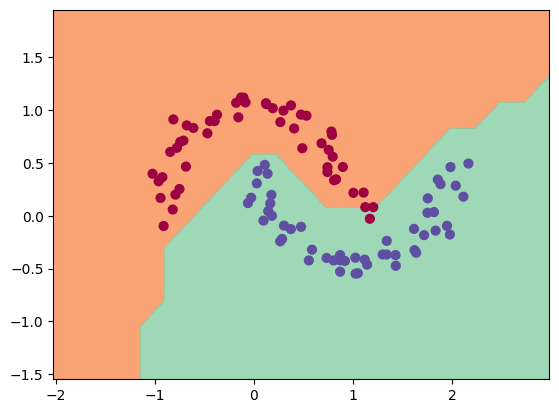

In [22]:

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = [model(x).sigmoid() for x in inputs]
Z = np.array([s.data > 0.5 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())